<h2> 3.6 Featurizing text data with tfidf weighted word-vectors </h2>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
import seaborn  as  sns
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from scipy import sparse

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve 
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics.classification import accuracy_score, log_loss 
from sklearn.metrics import confusion_matrix

In [2]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [3]:
dfnlp.head()

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,...,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,0.399992,0.199998,0.999950,0.666644,...,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.175000


In [4]:
dfppro.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [5]:
dfppro = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis = 1)

In [6]:
dfppro.head()

,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [7]:
df1  = dfnlp.merge(dfppro, on='id',how='left')

In [8]:
df1.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio', 'freq_qid1', 'freq_qid2',
       'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_Common',
       'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2'],
      dtype='object')

In [9]:
del(dfnlp,dfppro)

In [10]:
df1 = df1.head(100000)

In [11]:
df1_x = df1.drop(['is_duplicate'],axis=1)
df1_y = df1[['id','is_duplicate']]

In [12]:
X_train,X_test, y_train, y_test = train_test_split(df1_x, df1_y, test_size=0.3)

In [13]:
X_train['question1'] = X_train['question1'].apply(lambda x: str(x))
X_train['question2'] = X_train['question2'].apply(lambda x: str(x))
X_test['question1'] = X_test['question1'].apply(lambda x: str(x))
X_test['question2'] = X_test['question2'].apply(lambda x: str(x))

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(X_train['question1'] + X_train['question2'])

tfidf = TfidfVectorizer(lowercase=False)
tfidf_train = tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [15]:
questions = list(X_test['question1'] + X_test['question2'])
tfidf_test = tfidf.transform(questions)

- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

In [16]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(X_train['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), 96])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
X_train['q1_feats_m'] = list(vecs1)


100%|██████████| 70000/70000 [10:25<00:00, 111.86it/s]


In [17]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(X_test['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), 96])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
X_test['q1_feats_m'] = list(vecs1)

100%|██████████| 30000/30000 [04:18<00:00, 115.85it/s]


In [18]:
vecs2 = []
for qu2 in tqdm(list(X_train['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), 96])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
X_train['q2_feats_m'] = list(vecs2)

100%|██████████| 70000/70000 [09:53<00:00, 117.99it/s]


In [19]:
vecs2 = []
for qu2 in tqdm(list(X_test['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), 96])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
X_test['q2_feats_m'] = list(vecs2)

100%|██████████| 30000/30000 [04:07<00:00, 121.00it/s]


In [20]:
X_train_q1 = pd.DataFrame(X_train.q1_feats_m.values.tolist(), index= X_train.index)
X_train_q2 = pd.DataFrame(X_train.q2_feats_m.values.tolist(), index= X_train.index)

In [21]:
X_train_q1.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
15659,17.320557,17.309581,-67.318699,-28.424398,15.232775,39.156229,130.466557,80.710001,-19.715577,39.570485,...,26.462863,34.058403,2.039416,-3.215542,35.156383,35.258668,-59.325044,38.785767,-2.601623,4.925988
35444,48.856146,2.569419,-5.055871,-35.431297,-52.657208,29.183979,1.301936,5.009325,-18.539285,22.187981,...,17.115604,-56.424547,35.774836,2.475217,-9.587571,-3.069537,36.392845,-20.105957,-23.309000,39.366005
68562,105.450827,-33.894264,-3.969257,-81.560560,-75.363503,-33.611486,48.594091,78.160365,-58.005660,27.250475,...,22.156655,-41.638676,100.545773,47.470272,28.486521,-12.771987,40.811580,6.721989,-25.412029,21.353510
68370,67.417379,53.851522,-83.049466,-64.600549,32.419634,124.554298,138.364831,71.086139,-14.967142,42.149942,...,92.420457,-68.422230,18.744294,23.329126,46.335836,25.667803,-81.221453,8.032202,-7.781176,39.288746
10255,46.976337,-11.198918,20.596497,-67.707028,52.390532,107.468128,79.940606,34.855556,65.042741,71.737817,...,42.369710,-10.264457,52.155747,-60.673641,5.502124,25.569405,-5.430857,-18.328669,34.015818,7.654480


In [22]:
X_train_q2.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
15659,-8.968565,-58.924546,-18.111945,-32.211589,-4.591412,44.037832,86.187669,63.199941,-27.750468,57.257966,...,38.790349,6.417227,51.894864,-30.901261,-17.763131,36.825786,-37.379880,-24.054707,-38.778586,85.745141
35444,12.406575,-29.701209,-43.357018,-77.484966,-58.590760,28.108929,37.156789,-21.995720,17.324821,24.548412,...,6.358615,-83.278800,21.094343,40.515045,15.423308,55.957859,-21.368731,-10.521431,15.580367,42.280275
68562,90.444556,15.666121,-0.039949,-42.744730,-55.058437,-33.857150,4.637849,20.739877,-22.979693,18.454108,...,34.125774,-4.986566,19.527320,39.227552,16.493933,-1.061046,82.957511,29.372575,-10.130547,40.039223
68370,26.008050,-56.251587,-14.477676,-44.950713,-5.974411,-11.581484,98.101333,4.172291,72.905519,35.356393,...,74.209508,-9.563930,-9.990051,31.831249,-7.579658,-9.853520,-71.754162,-23.939064,-55.875440,16.681281
10255,35.692306,-75.377280,27.441088,-110.707287,-33.404513,21.120185,28.757781,21.449811,1.864017,96.534852,...,107.649658,-49.521651,87.932508,-22.009140,38.070376,13.961027,-61.009356,-50.378731,-48.824210,58.474072


In [23]:
# data before preprocessing 
X_train.head()

,id,qid1,qid2,question1,question2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,...,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,q1_feats_m,q2_feats_m
40897,40897,73933,73934,does software defined networking sdn comprom...,what is software defined networking sdn,0.999975,0.666656,0.000000,0.000000,0.666656,...,42,7,5,1.0,12.0,0.083333,4,2,"[82.49911522865295, -107.26408731937408, -118....","[20.21431541442871, -137.2736674360931, -71.28..."
26889,26889,49990,49991,what is the most tactless thing you have ever ...,what is the rudest thing you have ever done,0.749981,0.749981,0.999980,0.833319,0.888879,...,44,10,9,8.0,19.0,0.421053,7,3,"[-53.747671484947205, 1.557759165763855, -89.5...","[5.497439503669739, -11.983028292655945, -40.4..."
38803,38803,35658,70424,do you think the police in the us is too milit...,how and why did the police in the us become mi...,0.749981,0.749981,0.333328,0.333328,0.454541,...,56,11,11,5.0,20.0,0.250000,3,1,"[-28.73242175579071, 0.5792486667633057, -58.3...","[-12.847697138786316, 18.742434978485107, -58...."
91545,91545,153392,153393,i got a rank of 4130 in comedk what are the b...,i got 91 2 percent in cbse board 2015 can i g...,0.555549,0.333331,0.599988,0.333330,0.444442,...,85,18,17,7.0,34.0,0.205882,2,0,"[154.82669031620026, -105.60812520980835, -72....","[249.69486141204834, -116.83151239156723, -88...."
73967,73967,126855,126856,what is polar wind,what are polar wind,0.999950,0.999950,0.499975,0.499975,0.749981,...,20,4,4,3.0,8.0,0.375000,2,0,"[25.848376512527466, -7.2436976581811905, -27....","[34.287965536117554, -11.36777664348483, -26.9..."


In [24]:
# storing the final features to csv file
if not os.path.isfile('final_features_train.csv'):
    X_train_q1['id']=X_train['id']
    X_train_q2['id']=X_train['id']
    df1  = X_train_q1.merge(X_train_q2, on='id',how='left')
    result  = X_train.merge(df1, on='id',how='left')
    result = result.merge(y_train, on='id', how = 'left')
    result = result.drop(['id','qid1','qid2','question1','question2','q1_feats_m','q2_feats_m'],axis=1)
    result.to_csv('final_features_train.csv')

In [25]:
X_test_q1 = pd.DataFrame(X_test.q1_feats_m.values.tolist(), index= X_test.index)
X_test_q2 = pd.DataFrame(X_test.q2_feats_m.values.tolist(), index= X_test.index)

In [26]:
# storing the final features to csv file
if not os.path.isfile('final_features_test.csv'):
    X_test_q1['id']=X_test['id']
    X_test_q2['id']=X_test['id']
    df1  = X_test_q1.merge(X_test_q2, on='id',how='left')
    result  = X_test.merge(df1, on='id',how='left')
    result = result.merge(y_test, on='id', how = 'left')
    result = result.drop(['id','qid1','qid2','question1','question2','q1_feats_m','q2_feats_m'],axis=1)
    result.to_csv('final_features_test.csv')

In [16]:
result = X_train.drop(['id','qid1','qid2','question1','question2'],axis=1)
for i in result:
    result[i] = result[i].apply(pd.to_numeric)
    print(i)
result = sparse.hstack((result,tfidf_train))
result = result.todense()
X_train = pd.DataFrame(result)

cwc_min
cwc_max
csc_min
csc_max
ctc_min
ctc_max
last_word_eq
first_word_eq
abs_len_diff
mean_len
token_set_ratio
token_sort_ratio
fuzz_ratio
fuzz_partial_ratio
longest_substr_ratio
freq_qid1
freq_qid2
q1len
q2len
q1_n_words
q2_n_words
word_Common
word_Total
word_share
freq_q1+q2
freq_q1-q2


In [17]:
result = X_test.drop(['id','qid1','qid2','question1','question2'],axis=1)
for i in result:
    result[i] = result[i].apply(pd.to_numeric)
    print(i)
result = sparse.hstack((result,tfidf_test))
result = result.todense()
X_test = pd.DataFrame(result)

cwc_min
cwc_max
csc_min
csc_max
ctc_min
ctc_max
last_word_eq
first_word_eq
abs_len_diff
mean_len
token_set_ratio
token_sort_ratio
fuzz_ratio
fuzz_partial_ratio
longest_substr_ratio
freq_qid1
freq_qid2
q1len
q2len
q1_n_words
q2_n_words
word_Common
word_Total
word_share
freq_q1+q2
freq_q1-q2


In [18]:
del(result)

### 4.4 Logistic Regression with hyperparameter tuning

In [19]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

For values of alpha =  1e-05 The log loss is: 0.4713552851379316
For values of alpha =  0.0001 The log loss is: 0.46051725535054766
For values of alpha =  0.001 The log loss is: 0.4683521213509357
For values of alpha =  0.01 The log loss is: 0.44929951501910403
For values of alpha =  0.1 The log loss is: 0.4604261590398442
For values of alpha =  1 The log loss is: 0.49845666904032815
For values of alpha =  10 The log loss is: 0.5474122677828234


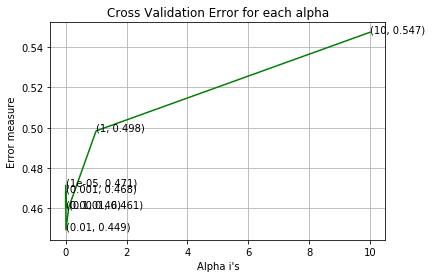

For values of best alpha =  0.01 The train log loss is: 0.44789936668374314
For values of best alpha =  0.01 The test log loss is: 0.44929951501910403
Total number of data points : 30000


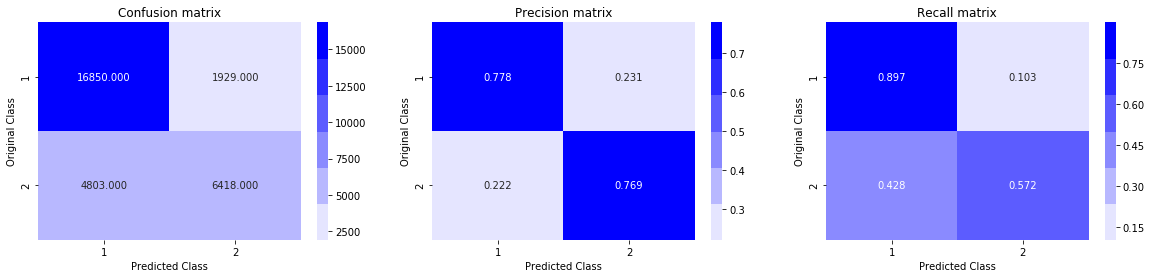

In [20]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

For values of alpha =  1e-05 The log loss is: 0.4787367485175869
For values of alpha =  0.0001 The log loss is: 0.4995959931448862
For values of alpha =  0.001 The log loss is: 0.5064090210685297
For values of alpha =  0.01 The log loss is: 0.5166099348414959
For values of alpha =  0.1 The log loss is: 0.5173817096203988
For values of alpha =  1 The log loss is: 0.6038987915326273
For values of alpha =  10 The log loss is: 0.6261408703574686


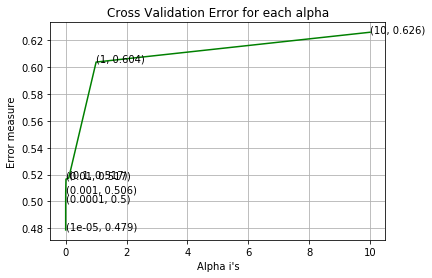

For values of best alpha =  1e-05 The train log loss is: 0.47526737305777383
For values of best alpha =  1e-05 The test log loss is: 0.4787367485175869
Total number of data points : 30000


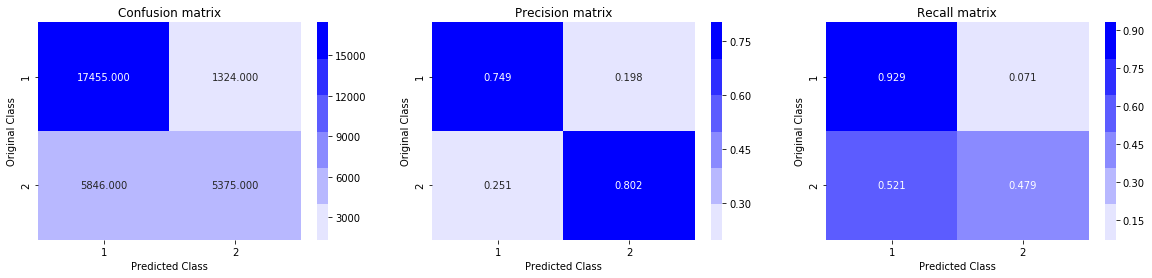

In [21]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [22]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer","Model","Hyper Parameter (alpha)","log loss"]
x.add_row(["TFIDF", "Logistic Regression", 0.01, 0.449])
x.add_row(["TFIDF", "Linear SVM", 0.00001, 0.478])

print(x)

+------------+---------------------+-------------------------+----------+
| Vectorizer |        Model        | Hyper Parameter (alpha) | log loss |
+------------+---------------------+-------------------------+----------+
|   TFIDF    | Logistic Regression |           0.01          |  0.449   |
|   TFIDF    |      Linear SVM     |          1e-05          |  0.478   |
+------------+---------------------+-------------------------+----------+
